In [ ]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from agglio_lib import *

In [ ]:
w_radius = 100

In [ ]:
boston_dataset = load_boston()
n,d=boston_dataset.data.shape

X = boston_dataset.data
X = normalize(X)

In [ ]:
x_avg=np.mean(X, axis=0)
x_std = np.std(X, axis=0)

In [ ]:
train_ind = np.random.choice(n, int(n*0.8), replace=False)
test_ind = np.setdiff1d(np.arange(n), train_ind)

X_train = X[train_ind]
X_test = X[test_ind]

y_train = boston_dataset.target[train_ind]
y_test = boston_dataset.target[test_ind]

In [ ]:
y_max, y_min, avg, std =max(y_train), min(y_train), np.mean(y_train), np.std(y_train)

B=1
y_train_trans = sigmoid((y_train - avg)/std,B).ravel()
y_test_trans = sigmoid((y_test - avg)/std,B).ravel()

max(y_train_trans), min(y_train_trans)

(0.9532790752804587, 0.1248895887387558)

In [ ]:
X_train.shape, y_train_trans.shape,  X_test.shape, y_test_trans.shape

((404, 13), (404,), (102, 13), (102,))

In [ ]:
w_linreg = np.linalg.pinv(X_train.T @ X_train)@ (X_train.T@y_train_trans)
y_linreg = X_test@w_linreg
mse_linreg=np.mean(np.power(y_test_trans-y_linreg, 2))
print("Linear Regression, Test MSE: ", mse_linreg)

Linear Regression, Test MSE:  0.009270533709495725


In [ ]:
w0 =  np.random.randn(d,1).ravel()
wAst =  np.zeros(shape=(d,1)).ravel()
MAX_ITER = 1000
BATCH_SIZE=50

In [ ]:
# AGGLIO-ADAM(the Library class is overwritten by this)

class AG_ADAM(BaseEstimator):
    def __init__( self, alpha = 0.1, B_init=0.1, B_step=1.01,  beta_1=0.9, beta_2=0.7, epsilon=np.power(10.0, -8)):
        self.alpha = alpha
        self.B_init = B_init
        self.B_step = B_step
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
    def fit( self, X_train, y_train, X_test, y_test, w_init, w_star, max_iter = 100, minibatch_size=20, temp_cap=1):
        X_train, y_train = check_X_y(X_train, y_train)
        X_test, y_test = check_X_y(X_test, y_test)
        
        n, d = X_train.shape
        t_start=time.time()
        indices= np.arange(n)
        self.distVals=[]
        self.train_mse=[]
        self.test_mse=[]
        self.clock=[]
        B=self.B_init
        
        m = np.zeros(shape=(d,))
        v  = np.zeros(shape=(d,))
        self.w=w=w_init
        train_mse = getObj(w, y_train, X_train)
        
        for i in range(max_iter):
            y_B = recompute_labels(y_train, B)
            # creating minibatch
            indices=np.random.permutation(indices)
            X_bat=X_train[indices[:minibatch_size]]
            y_B_bat=y_B[indices[:minibatch_size]]

            grad = getGrad(w, y_B_bat, X_bat, B)
            
            m=self.beta_1*m + (1-self.beta_1)*grad
            v= self.beta_2*v + (1-self.beta_2)*(grad**2)
            m_hat=m*(1/(1 -np.power(self.beta_1, i+1)))
            v_hat = v*(1/ (1 -np.power(self.beta_2, i+1)))
            w = w -  self.alpha*np.divide(m_hat, np.sqrt(v_hat)+self.epsilon)/(B*B)
            # projection
            if np.linalg.norm(w) > w_radius:
                w = w/np.linalg.norm(w)*w_radius
# plt.plot(num_list, err_list_AG_GD[0], color='#1b9e77', ls='--', linewidth=3)
# plt.plot(num_list, err_list_AG_GD[1], color='#5e3c99', ls='--', linewidth=3)
# plt.plot(num_list, err_list_AG_GD[2],  color='#d7191c', ls='--', linewidth=3)
# plt.plot(num_list, err_list_AG_GD[3],  color='#fdae61', ls='--',  linewidth=3)
            B = min(B * self.B_step, temp_cap)
            
            current_mse=getObj(w, y_train, X_train)
            if train_mse > current_mse:
                train_mse = current_mse
                self.w = w
                self.train_mse.append(getObj(w, y_train, X_train))
                self.test_mse.append(getObj(w, y_test, X_test))
                self.distVals.append(np.linalg.norm(self.w - w_star))
                self.clock.append(time.time()-t_start)
        return self

    def predict(self, X):
        return sigmoid(np.dot(X,self.w))
    
    def score( self, X, y ):
        return -mean_squared_error(y, self.predict(X))


In [ ]:
hparam={}
hparam['alpha']=np.power(10.0, [0, -1, -2, -3]).tolist()
hparam['B_init']=np.power(10.0, [0, -1, -2, -3]).tolist()
hparam['B_step']=np.linspace(start=1.01, stop=3, num=5).tolist()
hparam['beta_1'] = [0.3, 0.5, 0.7, 0.9]
hparam['beta_2'] = [0.3, 0.5, 0.7, 0.9]
#hparams['AG_ADAM']['epsilon'] = np.power(10.0, [-3,  -5, -8]).tolist()


cv = ShuffleSplit( n_splits = 1, test_size = 0.3, random_state = 42 )
grid = GridSearchCV( AG_ADAM(), param_grid=hparam, refit = False, cv=cv)
grid.fit( X_train, y_train_trans, X_test=X_test, y_test=y_test_trans, w_init=w0, w_star=wAst, minibatch_size=BATCH_SIZE)
best = grid.best_params_

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
#ag_adam = AG_ADAM(alpha= best["alpha"], B_init=best['B_init'], B_step=best['B_step'], beta_1=best['beta_1'],  beta_2=best['beta_2'], epsilon=best['epsilon'] )
ag_adam = AG_ADAM(alpha= best["alpha"], B_init=best['B_init'], B_step=best['B_step'], beta_1=best['beta_1'],  beta_2=best['beta_2'] )


The best parameters are {'B_init': 1.0, 'B_step': 1.5075, 'alpha': 1.0, 'beta_1': 0.9, 'beta_2': 0.7} with a score of -0.01


In [ ]:
ag_adam.fit( X_train, y_train_trans, X_test=X_test, y_test=y_test_trans, w_init=w0, w_star=wAst, max_iter=MAX_ITER )
print("AGGLIO ADAM Test MSE: ",ag_adam.test_mse[-1])

AGGLIO ADAM Test MSE:  0.012022877285445493


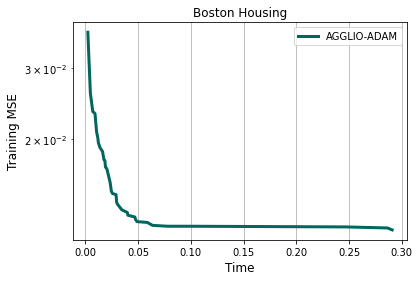

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

WIDTH=3

fig = plt.figure()
plt.plot(ag_adam.clock, ag_adam.train_mse, label='AGGLIO-ADAM',color='#01665e', linewidth=WIDTH)

plt.legend()
plt.ylabel("Training MSE",fontsize=12)
plt.xlabel("Time",fontsize=12)
plt.grid()
#plt.xlim(agd.clock[0], agd.clock[-1])
plt.yscale('log')
plt.title('Boston Housing')
plt.savefig('train_housing.pdf', dpi=300)
plt.show()

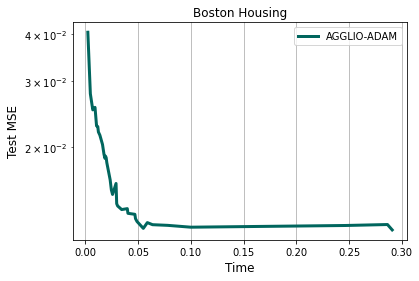

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

WIDTH=3

fig = plt.figure()
plt.plot(ag_adam.clock, ag_adam.test_mse, label='AGGLIO-ADAM',color='#01665e', linewidth=WIDTH)

plt.legend()
plt.ylabel("Test MSE",fontsize=12)
plt.xlabel("Time",fontsize=12)
plt.grid()
#plt.xlim(agd.clock[0], agd.clock[-1])
plt.yscale('log')
plt.title('Boston Housing')
plt.savefig('test_housing.pdf', dpi=300)
plt.show()

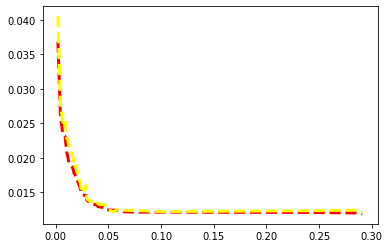

In [ ]:
plt.plot(ag_adam.clock, ag_adam.train_mse, label='AGGLIO-ADAM-Train',color='red',  ls='--', linewidth=WIDTH)
plt.plot(ag_adam.clock, ag_adam.test_mse, label='AGGLIO-ADAM-Test',color='yellow',  ls='--', linewidth=WIDTH)
plt.show()